#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.5em; color:#00b3e5;"> WaveNet - Stock Market Prediction
 - Note: **Date** is **( Optional )**

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import pickle, warnings
warnings.filterwarnings('ignore')

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from   sklearn.linear_model               import LinearRegression
from   statsmodels.tsa.statespace.sarimax import SARIMAX            # Seasonal ARIMA
from   tensorflow                         import keras

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Data

In [2]:
Project_Name = 'Google_Stock_Price'

data = pd.read_csv('Google_Stock_Price.csv')
data.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [3]:
# input
sclr = 'Low'

# auto
C = data[[sclr]].copy()
#for i in range(C.shape[0]):  C.loc[i,sclr] = C.loc[i,sclr].replace(",","") 

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> LOAD 

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">    

In [4]:
TimeSeries         = C.astype(float)
TimeSeries.columns =   ['Series']
TimeSeries.tail(3)

,Series
1255,783.20
1256,778.92
1257,770.41


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:orange;"> (optional) index = Date

In [5]:
TimeSeries.index = pd.to_datetime( data['Date'].values, format='%m/%d/%Y')
TimeSeries.tail(3)

,Series
2016-12-28,783.20
2016-12-29,778.92
2016-12-30,770.41


#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> Smooting Series

In [6]:
def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

def smoother2( df, ft, n ):   # Keeps Sharpness ( Good for small data-sets )
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+3*s[i]+s[i+1] ) / 5
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+3*s[i]+s[i+1] ) / 5
    noise = df[ft].values.copy() - s
    return s, noise

# input
n_smoothing = 1
smoothed, noise = smoother( TimeSeries, 'Series', n_smoothing )

# auto
TimeSeries[     'Noise'     ] = np.round( noise, 0 )  
TimeSeries['Smoothed_Series'] = np.round( smoothed, 0 ) 
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series
2016-12-28,783.20,2.0,781.0
2016-12-29,778.92,2.0,777.0
2016-12-30,770.41,0.0,770.0


<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;">   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Visualizing Smoothed-Series & Noise

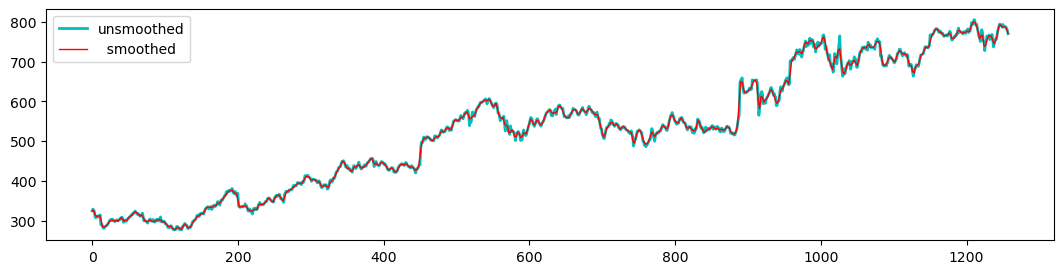

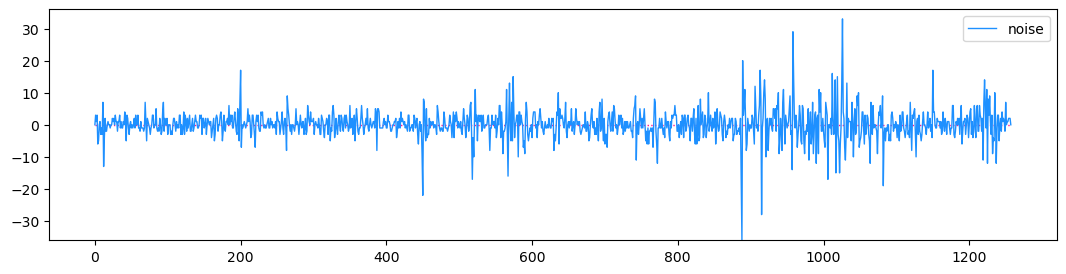

In [7]:
Range = range(TimeSeries.shape[0])
plt.figure(figsize=(13,3))
plt.plot(Range,TimeSeries[    'Series'     ],color='c',linewidth=2, label='unsmoothed' ) 
plt.plot(Range,TimeSeries['Smoothed_Series'],color='r',linewidth=1, label='  smoothed' )
plt.legend(); plt.show()

plt.figure(figsize=(13,3))
plt.plot( [Range[0],Range[-1]], [0,0], color='deeppink'  , linewidth=1, linestyle=':' )
plt.plot(  Range, TimeSeries['Noise'], color='dodgerblue', linewidth=1, label='noise' ) 
mx=max(abs(TimeSeries['Noise']));plt.gca().set_ylim(-mx,+mx); plt.legend()
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Trend & Initial_Value

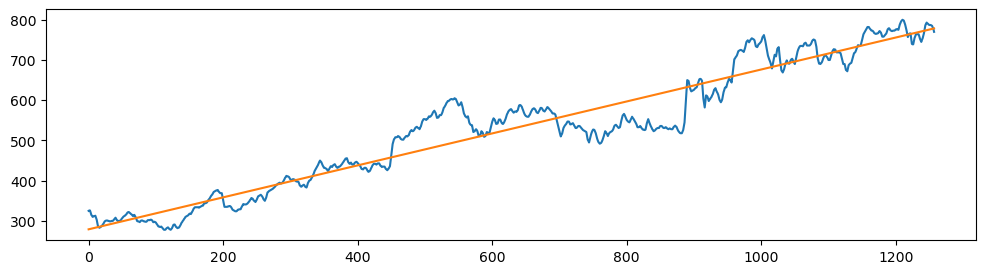

In [8]:
# Tend
T = pd.DataFrame( range( TimeSeries[ 'Smoothed_Series' ].shape[0] ))  
model = LinearRegression().fit( T, TimeSeries[['Smoothed_Series']] ) 

# trnd & initial values
trend         = model.coef_[0]     # slope
initial_value = model.intercept_   # intercept

# Trend
trend_line = trend*T + initial_value
TimeSeries['Trend'] = trend_line.values

# Plot
plt.figure(figsize=(12,3))
plt.plot( T, TimeSeries[['Smoothed_Series']] )
plt.plot( T, TimeSeries['Trend'] )
plt.show()

#####    

#####    

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic_Seasonality

In [9]:
#residual = y.values - trend_line.values
TimeSeries['Cyclic_Seasonality'] = TimeSeries['Smoothed_Series'] - TimeSeries['Trend']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality
2016-12-28,783.20,2.0,781.0,777.730615,3.269385
2016-12-29,778.92,2.0,777.0,778.127888,-1.127888
2016-12-30,770.41,0.0,770.0,778.525160,-8.525160


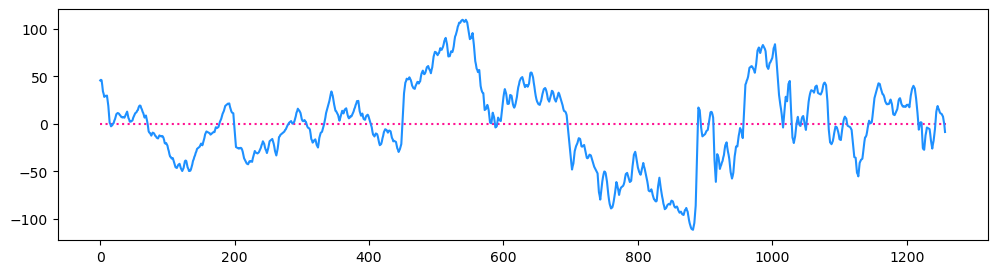

In [10]:
plt.figure( figsize=(12,3) )
plt.plot( [0,len(T)], [0,0], ':', color='deeppink' )
plt.plot( T, TimeSeries['Cyclic_Seasonality'], color='dodgerblue' )
plt.show()

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:orange;"> ( Optional ) Extracting Y, M, D from Dates

In [11]:
Dates = TimeSeries.index.date.tolist()
Dates[:3]

[datetime.date(2012, 1, 3),
 datetime.date(2012, 1, 4),
 datetime.date(2012, 1, 5)]

In [12]:
Dates = pd.to_datetime(Dates, format='%m/%d/%Y')
Dates[:3]

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05'], dtype='datetime64[ns]', freq=None)

In [13]:
df = pd.DataFrame()
df.index = Dates
df['Year' ] = Dates.year
df['month'] = Dates.month
df[ 'day' ] = Dates.day
df.sample(3)

,Year,month,day
2014-10-31,2014,10,31
2015-12-16,2015,12,16
2013-10-04,2013,10,4


In [14]:
Seasons = pd.concat([df,TimeSeries],axis=1) 
Seasons.tail(3)

,Year,month,day,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality
2016-12-28,2016,12,28,783.20,2.0,781.0,777.730615,3.269385
2016-12-29,2016,12,29,778.92,2.0,777.0,778.127888,-1.127888
2016-12-30,2016,12,30,770.41,0.0,770.0,778.525160,-8.525160


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:orange;"> ( Optional ) Visualizing Cyclic Seasonality

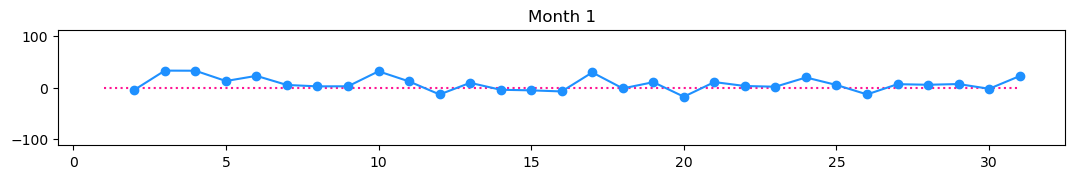

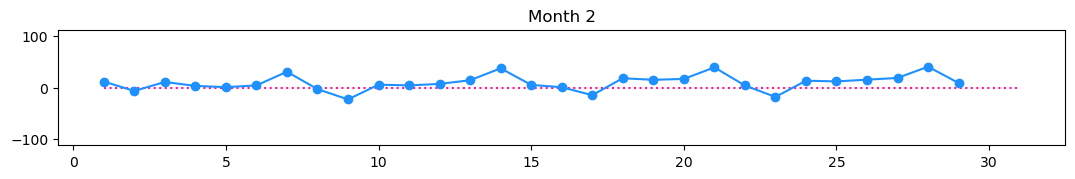

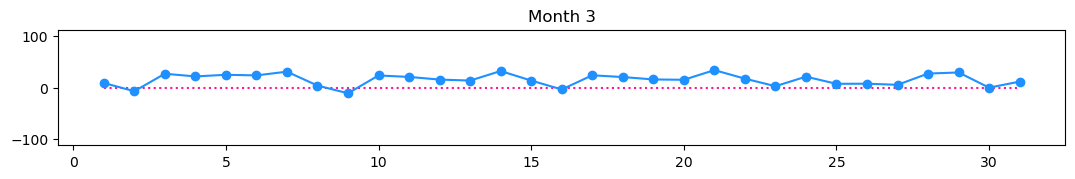

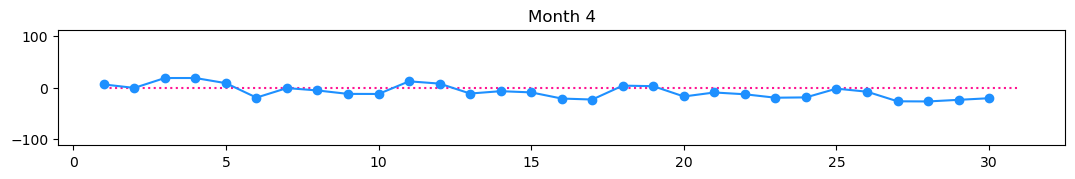

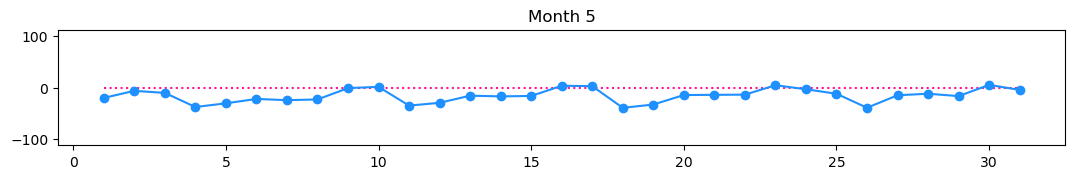

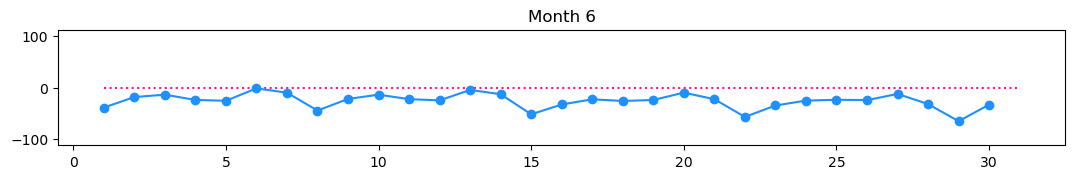

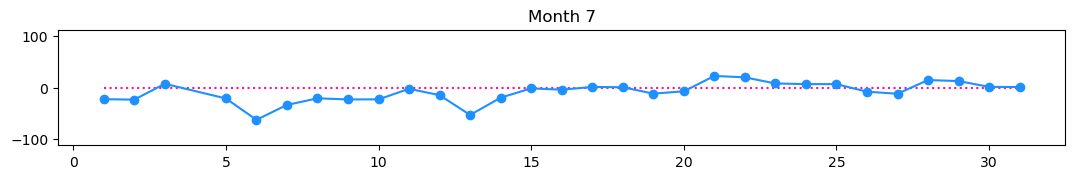

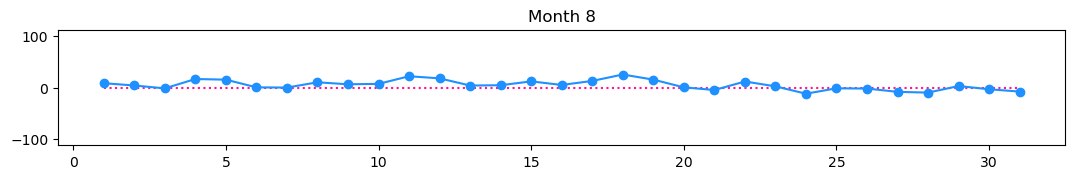

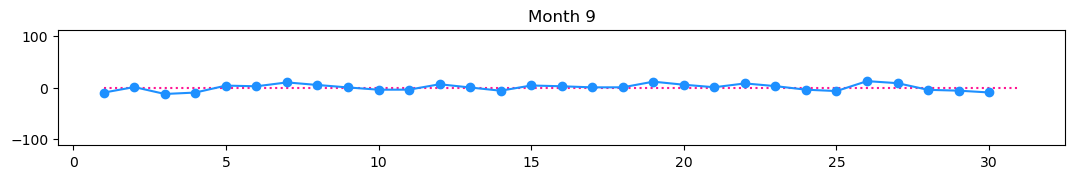

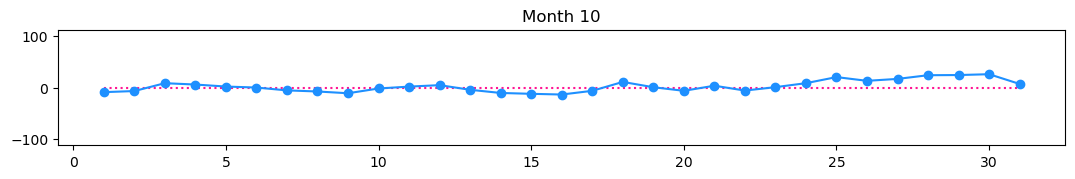

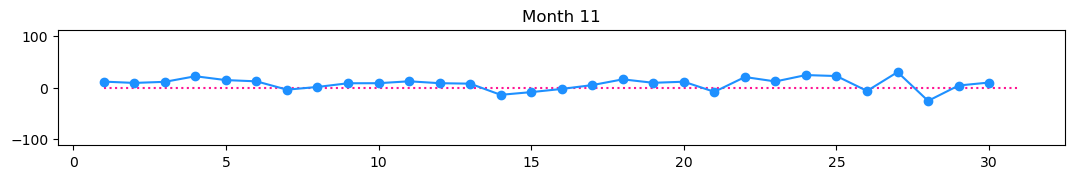

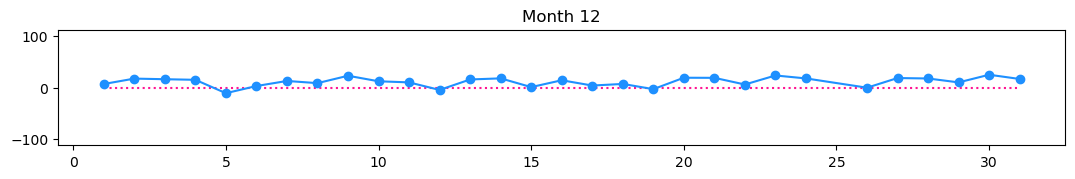

In [15]:
def plot_monthly_seasonality( df, ft, Month ): 
    A = df.loc[ df['month']==Month, ['day',ft] ].groupby('day').mean() 
    plt.figure(figsize=(13,1.5))
    plt.plot( [1,31],  [0,0], ':',  color='deeppink'   )
    plt.plot( A.index, A[ft], '-o', color='dodgerblue' )  
    YLIM = max(abs(df[ft]))
    plt.gca().set_ylim(-YLIM,+YLIM)
    plt.title('Month '+str(Month))
    plt.show()
    
for i in range(1,13):
    plot_monthly_seasonality( Seasons, 'Cyclic_Seasonality', i )

#####    

#####    

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> Cyclicity

[0, array([5.30137287e+01, 1.19463601e-02, 4.21553034e+02, 9.96714161e-02]), 30.01874188433749]


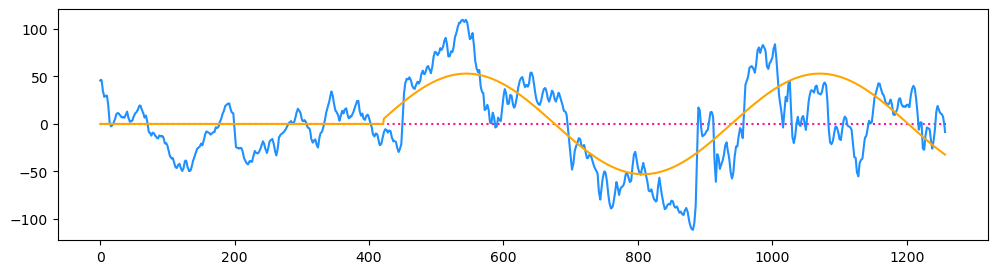

In [16]:
res = TimeSeries['Cyclic_Seasonality'].values.copy()
T   = range( len(res) ) 
As, ws, Tos, lags = [],[],[],[]

for i in range(1):
    # The Function To Be Minimized 
    def obj_func(p):   
        A, w, To, lag  = p  
        sig = []
        for t in range(TimeSeries.shape[0]):
            if t <= To:   sig.append( 0 )
            else      :   sig.append( A * np.sin(w*(t-To)+lag) )
        SE = [ (i-j)**2 for i,j in zip(res,sig) ]
        return ( sum(SE)/len(SE) ) ** 0.5

    from sko.GA import GA
    ga = GA( func      = obj_func
           , n_dim     = 4
           , size_pop  = 350 
           , max_iter  = 100 
           , ub        = [2*np.max(res), 2*np.pi,  T[-1] , 2*np.pi]
           , lb        = [   0.00001,    0.00001, 0.00001, 0.00001]
           , prob_mut  = 0.05
           , precision = 0.0001
           )
    Best_X, Best_y = ga.fit()
    A, w, To, lag = Best_X
    As.append(A)
    ws.append(w)
    Tos.append(To)
    lags.append(lag)    
    print([i, Best_X, Best_y])
    sig = []
    for t in range(TimeSeries.shape[0]):
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    res = res - sig
    
df_Cyclicity = pd.DataFrame()
df_Cyclicity['Cycle'] = range(len(As))
df_Cyclicity[  'A'  ] =  As
df_Cyclicity[  'w'  ] =  ws
df_Cyclicity[  'To' ] =  Tos
df_Cyclicity[ 'lag' ] =  lags

res = TimeSeries['Cyclic_Seasonality'].values.copy()
T   = range( TimeSeries.shape[0] ) 

SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A'  ]
    w   = df_Cyclicity.loc[i, 'w'  ]
    To  = df_Cyclicity.loc[i, 'To' ]
    lag = df_Cyclicity.loc[i, 'lag']
    sig = []
    for t in T:
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    SIG = [ i+j for i,j in zip(SIG,sig) ]
TimeSeries['Cyclicity'] = SIG
       
pickle.dump( trend        ,  open(Project_Name + '_trend'        ,'wb') )  # save
pickle.dump( initial_value,  open(Project_Name + '_initial_value','wb') )  # save
pickle.dump( df_Cyclicity ,  open(Project_Name + '_df_Cyclicity' ,'wb') )  # save
pickle.dump( TimeSeries   ,  open(Project_Name + '_TimeSeries'   ,'wb') )  # save

plt.figure(figsize=(12,3))
plt.plot( [0,len(T)], [0,0], color='deeppink', linestyle=":" )
plt.plot(    T,        res , color='dodgerblue' )
plt.plot(    T,        SIG , color='orange'     )
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [17]:
df_Cyclicity

,Cycle,A,w,To,lag
0,0,53.013729,0.011946,421.553034,0.099671


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [18]:
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity
2016-12-28,783.20,2.0,781.0,777.730615,3.269385,-31.299163
2016-12-29,778.92,2.0,777.0,778.127888,-1.127888,-31.808079
2016-12-30,770.41,0.0,770.0,778.525160,-8.525160,-32.312455


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> continue ...

[2, array([2.52744320e+01, 6.94230498e-02, 8.31954326e+02, 3.02700380e+00]), 23.78310644836955]
[3, array([1.48986677e+01, 3.83118141e-02, 6.74721785e+01, 3.44348210e+00]), 21.351004683807684]
[4, array([1.48858837e+01, 8.54281965e-03, 7.15667602e+01, 4.07471901e+00]), 19.261920191879724]
[5, array([1.57192461e+01, 1.96642475e-02, 7.97986767e+02, 3.52670106e+00]), 18.2403924577871]
[6, array([1.14963358e+01, 4.79471891e-02, 2.65179546e+02, 1.66822418e+00]), 17.220150617571896]
[7, array([1.50492494e+01, 8.28933999e-02, 8.74599621e+02, 5.18110933e+00]), 16.225204317858747]
[8, array([9.94216962e+00, 1.46458113e-01, 2.76423284e+02, 4.95264069e+00]), 15.518264297918009]
[9, array([1.00221941e+01, 1.18846292e-01, 7.32363062e+02, 9.13453138e-01]), 14.933807924768638]
[10, array([  9.9851009 ,   6.23635067, 939.21276403,   4.21781152]), 14.32215818907131]
[11, array([1.15360368e+01, 3.36193507e-01, 8.46599308e+02, 5.25339861e+00]), 13.711041246633455]
[12, array([  2.57213072,   6.21310114, 

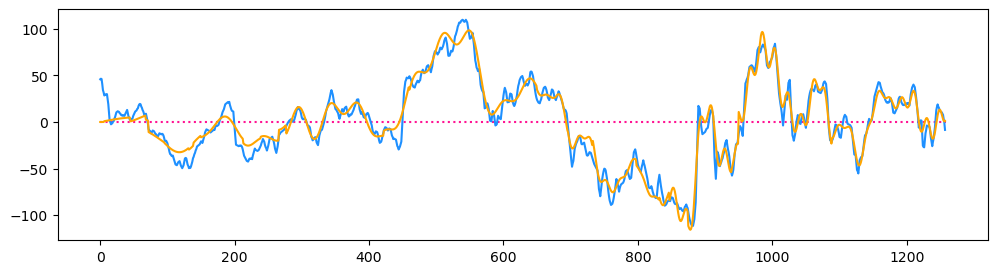

In [68]:
# input
n_Extra = 24

# auto
try:
    df_Cyclicity = pickle.load( open(Project_Name + '_df_Cyclicity','rb') )  # load
    TimeSeries   = pickle.load( open(Project_Name + '_TimeSeries'  ,'rb') )  # load
except:
    ;

# auto
res  = TimeSeries['Cyclic_Seasonality'].values.copy() - TimeSeries['Cyclicity'].values.copy() 
T    = range( TimeSeries.shape[0] )
As   = df_Cyclicity[ 'A' ].values.copy().tolist()
ws   = df_Cyclicity[ 'w' ].values.copy().tolist()
Tos  = df_Cyclicity[ 'To'].values.copy().tolist()
lags = df_Cyclicity['lag'].values.copy().tolist()

for i in range( len(As), len(As)+n_Extra ):
    # The Function To Be Minimized 
    def obj_func(p):   
        A, w, To, lag  = p  
        sig = []
        for t in range(TimeSeries.shape[0]):
            if t <= To:   sig.append( 0 )
            else      :   sig.append( A * np.sin(w*(t-To)+lag) )
        SE = [ (i-j)**2 for i,j in zip(res,sig) ]
        return ( sum(SE)/len(SE) ) ** 0.5

    from sko.GA import GA
    ga = GA( func      = obj_func
           , n_dim     = 4
           , size_pop  = 350
           , max_iter  = 100 
           , ub        = [2*np.max(res), 2*np.pi,  T[-1] , 2*np.pi]
           , lb        = [   0.00001,    0.00001, 0.00001, 0.00001]
           , prob_mut  = 0.05
           , precision = 0.0001
           )
    Best_X, Best_y = ga.fit()
    A, w, To, lag = Best_X
    As.append(A)
    ws.append(w)
    Tos.append(To)
    lags.append(lag)    
    print([i, Best_X, Best_y])
    sig = []
    for t in range(TimeSeries.shape[0]):
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    res = res - sig
    
df_Cyclicity = pd.DataFrame()
df_Cyclicity['Cycle'] = range(len(As))
df_Cyclicity[  'A'  ] =  As
df_Cyclicity[  'w'  ] =  ws
df_Cyclicity[  'To' ] =  Tos
df_Cyclicity[ 'lag' ] =  lags

# Save & Plot
CS  = TimeSeries['Cyclic_Seasonality'].values.copy() 

SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A'  ]
    w   = df_Cyclicity.loc[i, 'w'  ]
    To  = df_Cyclicity.loc[i, 'To' ]
    lag = df_Cyclicity.loc[i, 'lag']
    sig = []
    for t in range(TimeSeries.shape[0]):
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    SIG = [ i+j for i,j in zip(SIG,sig)  ]
TimeSeries['Cyclicity'] = SIG

pickle.dump( trend        ,  open(Project_Name + '_trend'        ,'wb') )  # save
pickle.dump( initial_value,  open(Project_Name + '_initial_value','wb') )  # save
pickle.dump( df_Cyclicity ,  open(Project_Name + '_df_Cyclicity' ,'wb') )  # save
pickle.dump( TimeSeries   ,  open(Project_Name + '_TimeSeries'   ,'wb') )  # save

plt.figure(figsize=(12,3))
plt.plot( [0,len(T)], [0,0], color='deeppink', linestyle=":" )
plt.plot(    T,        CS  , color='dodgerblue' )
plt.plot(    T,        SIG , color='orange'     )
plt.show()

#####    

#####    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Load

In [69]:
trend         = pickle.load( open(Project_Name + '_trend'        ,'rb') )  # load
initial_value = pickle.load( open(Project_Name + '_initial_value','rb') )  # load
df_Cyclicity  = pickle.load( open(Project_Name + '_df_Cyclicity' ,'rb') )  # load
TimeSeries    = pickle.load( open(Project_Name + '_TimeSeries'   ,'rb') )  # load

#####    

#####    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Cyclic Trend

In [70]:
TimeSeries['Cyclic_Trend'] = TimeSeries['Trend']+TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend
2016-12-28,783.20,2.0,781.0,777.730615,3.269385,1.427143,779.157758
2016-12-29,778.92,2.0,777.0,778.127888,-1.127888,0.605179,778.733067
2016-12-30,770.41,0.0,770.0,778.525160,-8.525160,1.163852,779.689012


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

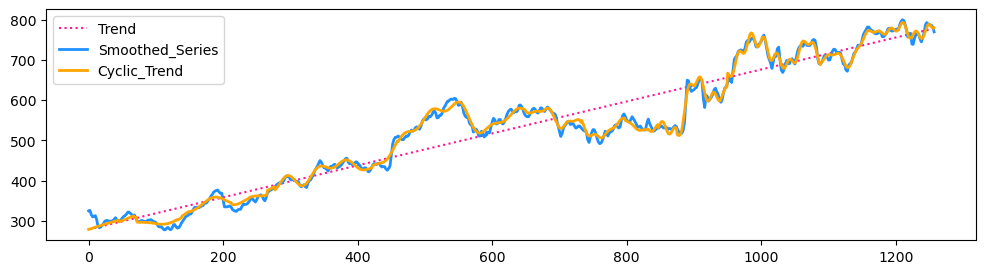

In [71]:
T = range( TimeSeries.shape[0] )
y1 = TimeSeries['Trend']
y2 = TimeSeries['Smoothed_Series']
y3 = TimeSeries['Cyclic_Trend']

plt.figure(figsize=(12,3))
plt.plot(T,y1,color='deeppink'  ,linestyle=':',label='Trend'          )
plt.plot(T,y2,color='dodgerblue',linewidth=2  ,label='Smoothed_Series')
plt.plot(T,y3,color='orange'    ,linewidth=2  ,label='Cyclic_Trend'   )
plt.legend()
plt.show()

#####    

#####    

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Seasonality

In [72]:
TimeSeries['Seasonality'] = TimeSeries['Cyclic_Seasonality'] - TimeSeries['Cyclicity']
TimeSeries.tail(3)

,Series,Noise,Smoothed_Series,Trend,Cyclic_Seasonality,Cyclicity,Cyclic_Trend,Seasonality
2016-12-28,783.20,2.0,781.0,777.730615,3.269385,1.427143,779.157758,1.842242
2016-12-29,778.92,2.0,777.0,778.127888,-1.127888,0.605179,778.733067,-1.733067
2016-12-30,770.41,0.0,770.0,778.525160,-8.525160,1.163852,779.689012,-9.689012


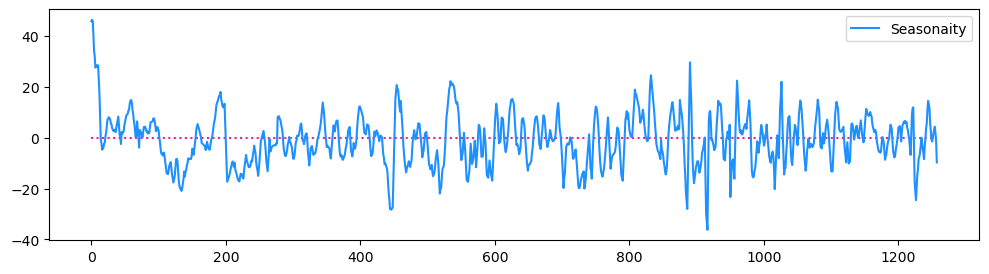

In [73]:
T = range( TimeSeries.shape[0] )
y = TimeSeries['Seasonality'] 

plt.figure(figsize=(12,3))
plt.plot([T[0],T[-1]],[0,0],color='deeppink', linestyle=':'        )
plt.plot(T,y,color='dodgerblue', linestyle='-', label='Seasonaity' )
plt.legend()
plt.show()

#####    

#####    

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> SARIMA

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> n_Test
 - **choosing the last n records as test (shown in orange)**

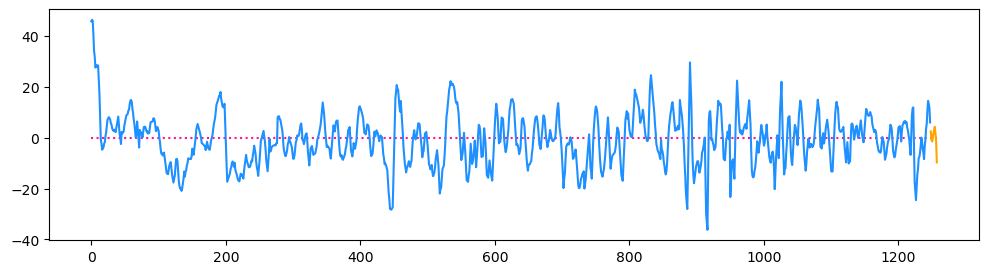

In [74]:
# input
n = 10   # n = n_Steps = n_Test

# Serie 
Series   = TimeSeries['Seasonality'].values.tolist()[:-n]
n_Series = len(Series)
T_Series = range(n_Series)

# Test
Test     = TimeSeries['Seasonality'].values.tolist()[-n:]
n_Test   = n
T_Test   = range( n_Series, n_Series+n_Test )

# Visualization
plt.figure(figsize=(12,3)); 
plt.plot( [T_Series[0],T_Test[-1]],[0,0], ":", color='deeppink' )
plt.plot( T_Series, Series, color='dodgerblue' )
plt.plot( T_Test  , Test  , color='orange'     )
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checking
 - **checking if Time-Series is Trend-Stationary (meaning both mean and std remain constant over time)**

In [75]:
from statsmodels.tsa.stattools import adfuller

print("\nAugmented Dickey-Fuller Unit Root Test") 
stat, p, lags, obs, crit, t = adfuller( Series )

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: 
    print('\nWarning!')
    print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)  ---   NOT OK')
    print('Hint: Add more Cycles')
else: 
    print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK')


Augmented Dickey-Fuller Unit Root Test
stat=-8.592, p=0.000
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [76]:
from statsmodels.tsa.stattools import kpss
print("\nKwiatkowski-Phillips-Schmidt-Shin Test")  
stat, p, lags, crit = kpss( Series )
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05: 
    print('Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK')
else: 
    print('\nWarning!')
    print('Time-Series is "Not Trend-Stationary"   (mean & variance  vary  over time)  ---   NOT OK')
    print('Hint: Add more Cycles')


Kwiatkowski-Phillips-Schmidt-Shin Test
stat=0.110, p=0.100
Time-Series is "Trend-Stationary"   (mean & variance  remain constant  over time)  ---   OK


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

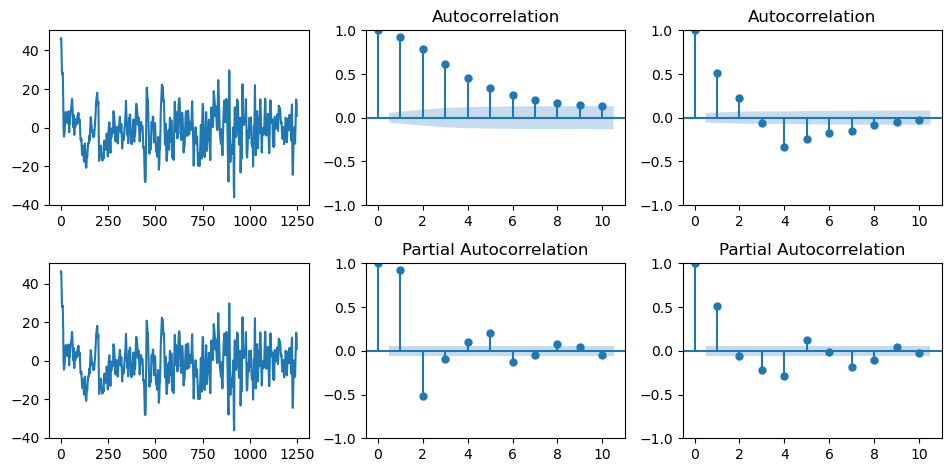

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = pd.DataFrame(Series)
fig, axes = plt.subplots(2,3)
axes[0,0].plot(ts)
plot_acf( ts, lags=n_Test, ax=axes[0,1] )
plot_acf( ts.diff().dropna(), lags=n_Test, ax=axes[0,2] )
axes[1,0].plot(ts)
plot_pacf( ts, lags=n_Test, ax=axes[1,1] )
plot_pacf( ts.diff().dropna(), lags=n_Test, ax=axes[1,2] )
plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=(0, 0, 1.5, 1))

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [78]:
PDQs, RMSEs,AICs,BICs = [], [], [], []

n_pq = 6
for p in range(n_pq):
    for d in range(2):
        for q in range(n_pq):
            
            try:
                sarimax = SARIMAX(
                    endog                   =  Series,
                    order                   = (p,d,q),
                    seasonal_order          = (0, 0, 0, 0),
                    trend_offset            =  1,
                    trend                   =  None,   # None,'n','c','t','ct'
                    exog                    =  None,
                    dates                   =  None,
                    freq                    =  None,
                    mle_regression          =  True,
                    enforce_stationarity    =  True,
                    enforce_invertibility   =  True,
                    validate_specification  =  True,
                    time_varying_regression =  False,
                    hamilton_representation =  False, 
                    simple_differencing     =  False,
                    concentrate_scale       =  False,
                    measurement_error       =  False,
                    use_exact_diffuse       =  False,   
                    missing                 = 'none'
                    )
                model = sarimax.fit()
                
                print( 'p, d, q =', [p,d,q] )
         
                PRED    = [ x for x in model.forecast(steps=n_Test) ] 
                SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
                RMSE    =   (np.sum(SE)/n_Test)**0.5
                RMSEs.append(np.round(RMSE,1))
                
                PDQs.append( (p,d,q) )
                AICs.append(int(np.round(model.aic,-1)))
                BICs.append(int(np.round(model.bic,-1)))
        
            except:
                continue

p, d, q = [0, 0, 0]
p, d, q = [0, 0, 1]
p, d, q = [0, 0, 2]
p, d, q = [0, 0, 3]
p, d, q = [0, 0, 4]
p, d, q = [0, 0, 5]
p, d, q = [0, 1, 0]
p, d, q = [0, 1, 1]
p, d, q = [0, 1, 2]
p, d, q = [0, 1, 3]
p, d, q = [0, 1, 4]
p, d, q = [0, 1, 5]
p, d, q = [1, 0, 0]
p, d, q = [1, 0, 1]
p, d, q = [1, 0, 2]
p, d, q = [1, 0, 3]
p, d, q = [1, 0, 4]
p, d, q = [1, 0, 5]
p, d, q = [1, 1, 0]
p, d, q = [1, 1, 1]
p, d, q = [1, 1, 2]
p, d, q = [1, 1, 3]
p, d, q = [1, 1, 4]
p, d, q = [1, 1, 5]
p, d, q = [2, 0, 0]
p, d, q = [2, 0, 1]
p, d, q = [2, 0, 2]
p, d, q = [2, 0, 3]
p, d, q = [2, 0, 4]
p, d, q = [2, 0, 5]
p, d, q = [2, 1, 0]
p, d, q = [2, 1, 1]
p, d, q = [2, 1, 2]
p, d, q = [2, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [2, 1, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [2, 1, 5]
p, d, q = [3, 0, 0]
p, d, q = [3, 0, 1]
p, d, q = [3, 0, 2]
p, d, q = [3, 0, 3]
p, d, q = [3, 0, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [3, 0, 5]
p, d, q = [3, 1, 0]
p, d, q = [3, 1, 1]
p, d, q = [3, 1, 2]
p, d, q = [3, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [3, 1, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [3, 1, 5]
p, d, q = [4, 0, 0]
p, d, q = [4, 0, 1]
p, d, q = [4, 0, 2]
p, d, q = [4, 0, 3]
p, d, q = [4, 0, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 0, 5]
p, d, q = [4, 1, 0]
p, d, q = [4, 1, 1]
p, d, q = [4, 1, 2]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 1, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [4, 1, 5]
p, d, q = [5, 0, 0]
p, d, q = [5, 0, 1]
p, d, q = [5, 0, 2]
p, d, q = [5, 0, 3]
p, d, q = [5, 0, 4]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [5, 0, 5]
p, d, q = [5, 1, 0]
p, d, q = [5, 1, 1]
p, d, q = [5, 1, 2]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [5, 1, 3]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p, d, q = [5, 1, 4]
p, d, q = [5, 1, 5]


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [79]:
df = pd.DataFrame( [RMSEs,PDQs,AICs,BICs] ).T
df.columns = ['rmse','( p, d, q )','aic','bic']
df.sort_values(['rmse','bic','aic'],ascending=[True,True,True],inplace=True)
df.head(10)

,rmse,"( p, d, q )",aic,bic
46,3.6,"(3, 1, 4)",6010,6050
35,3.6,"(2, 1, 5)",6010,6060
63,3.6,"(5, 0, 3)",6010,6060
70,3.6,"(5, 1, 4)",6010,6060
62,3.6,"(5, 0, 2)",6020,6060
69,3.6,"(5, 1, 3)",6020,6070
15,3.7,"(1, 0, 3)",6010,6040
16,3.7,"(1, 0, 4)",6010,6040
22,3.7,"(1, 1, 4)",6010,6040
27,3.7,"(2, 0, 3)",6010,6040


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [100]:
order = df['( p, d, q )']
order.index = range(len(order))
best_order = order[0]
best_order

(3, 1, 4)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [101]:
# SARIMAX
sarimax = SARIMAX(
    endog                   =  Series,
    order                   =  best_order,
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1248
Model:               SARIMAX(3, 1, 4)   Log Likelihood               -2998.815
Date:                Sat, 18 Jan 2025   AIC                           6013.629
Time:                        01:55:41   BIC                           6054.657
Sample:                             0   HQIC                          6029.055
                               - 1248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7008      0.052     13.431      0.000       0.599       0.803
ar.L2         -0.0090      0.070     -0.127      0.899      -0.147       0.129
ar.L3          0.0616      0.038      1.637      0.1

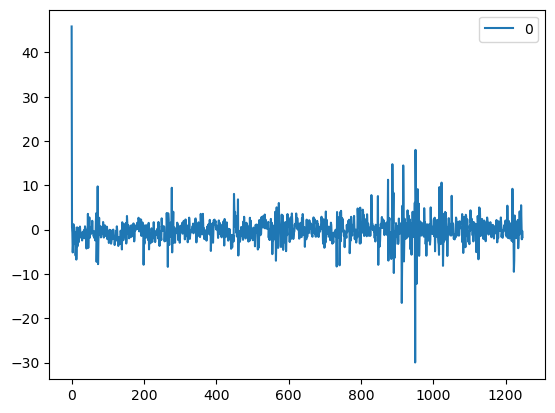

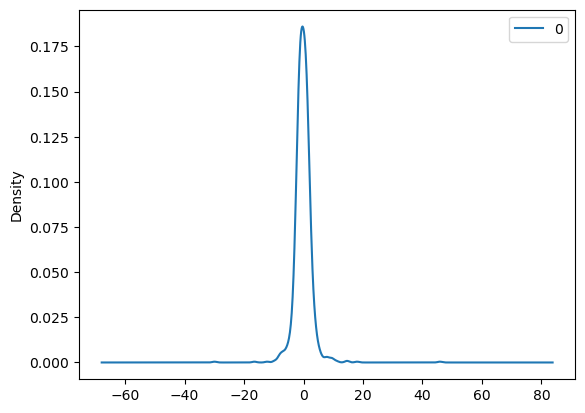

                 0
count  1248.000000
mean     -0.144591
std       2.973544
min     -29.979353
25%      -1.512914
50%      -0.191232
75%       1.154910
max      45.846305


In [102]:
# fitted model
model = sarimax.fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

In [103]:
# forcasting  
PRED    = [ x for x in model.forecast(steps=n_Test) ] 
SE      = [ (i-j)**2 for i,j in zip(PRED,Test) ]
RMSE    =   (np.sum(SE)/n_Test)**0.5
RMSE

3.6488028265191685

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

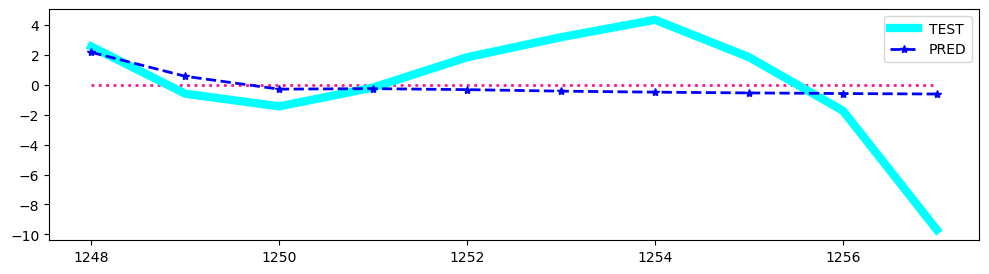

In [104]:
# visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_Test[0],T_Test[-1]], [0,0] ,  ":"  ,                color='deeppink' ,linewidth=2 )
plt.plot(        T_Test         , Test  ,  "-"  , label="TEST" , color='cyan'     ,linewidth=6 )
plt.plot(        T_Test         , PRED  , "--*" , label="PRED" , color='blue'     ,linewidth=2 )
plt.legend(); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;">    

#####  

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> input

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


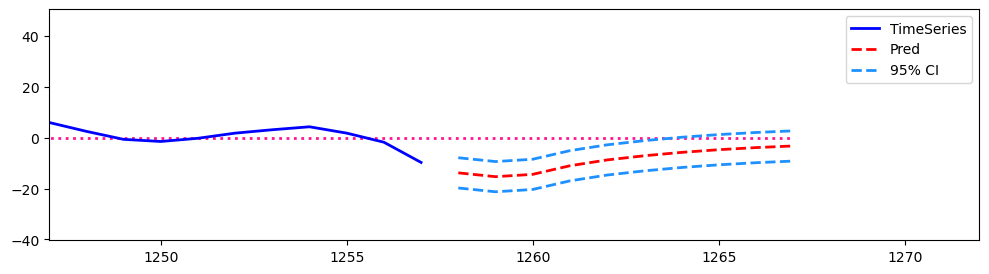

In [105]:
# auto
SD      = residuals.describe().loc['std',0]
n_Steps = n_Test 

TS = Series+Test 
n_TS =  len(    TS )
T_TS = range( n_TS )

model = SARIMAX(
    endog                   =  TS,
    order                   =  best_order,
    seasonal_order          = (0, 0, 0, 0),
    trend_offset            =  1,
    trend                   =  None,        # None,'n','c','t','ct'
    exog                    =  None,
    dates                   =  None,
    freq                    =  None,
    mle_regression          =  True,
    enforce_stationarity    =  True,
    enforce_invertibility   =  True,
    validate_specification  =  True,
    time_varying_regression =  False,
    hamilton_representation =  False, 
    simple_differencing     =  False,
    concentrate_scale       =  False,
    measurement_error       =  False,
    use_exact_diffuse       =  False,   
    missing                 = 'none'
).fit() 

# Forecasting Unknown Future
Pred        = [ x for x in model.forecast(steps=n_Steps) ]
T_Pred      = range( n_TS, n_TS+n_Steps )

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Pred ]
Pred_68_Top = [ x+1*SD for x in Pred ] 
Pred_68_Bot = [ x-1*SD for x in Pred ] 
Pred_95_Bot = [ x-2*SD for x in Pred ]  

# Visualizing
plt.figure( figsize=(12,3) )
plt.plot( [T_TS[0],T_Pred[-1]],   [0,0]    ,  ":" , color='deeppink'  , linewidth=2                     ) 
plt.plot(          T_TS       , TS ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Pred       , "--" , color='red'       , linewidth=2, label="Pred"       )
plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( T_Pred[-1]-2*n_Steps, T_Pred[-1]+5 )
#plt.ylim([-12,+10])
plt.legend(); plt.show()

#####   

In [106]:
T = T_Pred
T

range(1258, 1268)

In [107]:
TREND = trend*T + initial_value
TREND 

array([778.92243247, 779.31970492, 779.71697736, 780.11424981,
       780.51152225, 780.9087947 , 781.30606715, 781.70333959,
       782.10061204, 782.49788449])

In [108]:
SIG = [0 for t in T]
for i in range(df_Cyclicity.shape[0]):
    A   = df_Cyclicity.loc[i, 'A' ]
    w   = df_Cyclicity.loc[i, 'w' ]
    To  = df_Cyclicity.loc[i, 'To']
    lag = df_Cyclicity.loc[i,'lag']
    sig = []
    for t in T:
        if t <= To:   sig.append( 0 )
        else      :   sig.append( A * np.sin(w*(t-To)+lag) )
    SIG = [ i+j for i,j in zip(SIG,sig) ]
np.array(SIG)

array([ 3.25203758,  6.84710488, 11.75687632, 17.64191379, 24.05557471,
       30.49711659, 36.47150242, 41.54868341, 45.41512094, 47.91117086])

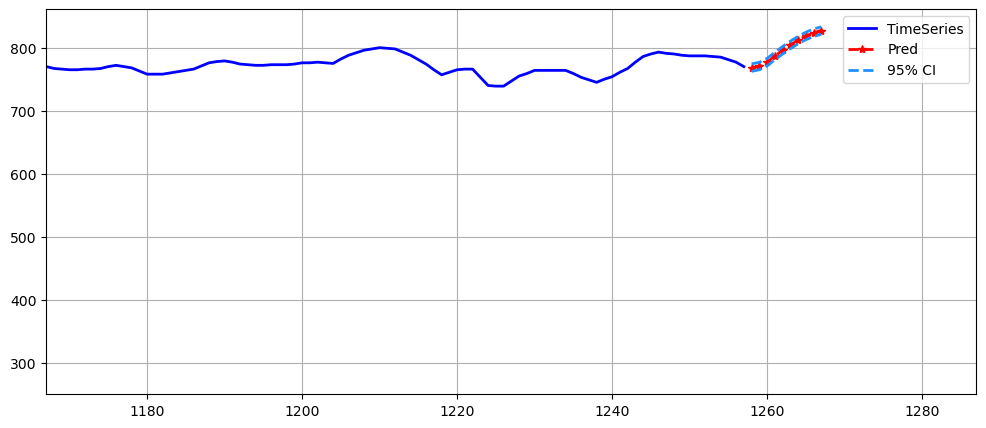

In [109]:
# Forecasting Unknown Future 
Full_Pred = [ x1+x2+x3 for x1,x2,x3 in zip(TREND,SIG,Pred) ]
#Full_Pred = [ x1+x2 for x1,x2 in zip(TREND,SIG) ]

# Confidence Interval
Pred_95_Top = [ x+2*SD for x in Full_Pred ]
Pred_68_Top = [ x+1*SD for x in Full_Pred ] 
Pred_68_Bot = [ x-1*SD for x in Full_Pred ] 
Pred_95_Bot = [ x-2*SD for x in Full_Pred ]   

# Visualizing
plt.figure( figsize=(12,5) )
plt.plot(       T_TS     , TimeSeries['Smoothed_Series'] ,  "-" , color='blue'      , linewidth=2, label="TimeSeries" )
plt.plot(          T_Pred             , Full_Pred       , "--*" , color='red'       , linewidth=2, label="Pred"       )
plt.plot(          T_Pred             , Pred_95_Top, "--" , color='dodgerblue', linewidth=2, label="95% CI"     )
#plt.plot(          T_Pred             , Pred_68_Top, "--" , color='lime'      , linewidth=2, label="68% CI"     )
#plt.plot(          T_Pred             , Pred_68_Bot, "--" , color='lime'      , linewidth=2                     )
plt.plot(          T_Pred             , Pred_95_Bot, "--" , color='dodgerblue', linewidth=2                     ) 
plt.xlim( T_Pred[-1]-10*n_Steps, T_Pred[-1]+2*n_Steps )
#plt.ylim([760,810])
plt.legend(); plt.grid('on'); plt.show()

#####   

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smoothed Series

In [110]:
# functions
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [111]:
S = TimeSeries[['Smoothed_Series']].values.astype('float32') 
S = S[:,0]
S

array([325., 326., 326., ..., 781., 777., 770.], dtype=float32)

In [112]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [113]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.98,1.02)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [114]:
N      = n_Steps
nBatch = 1000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [115]:
# (3) Best   WaveNet 
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 



model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8, 16) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))


print('Model Defined.')

Model Defined.


In [116]:
# load weights
version = '00'
try:
    model.load_weights(
          Project_Name  + '_' + version 
        , by_name       = False 
        , skip_mismatch = False 
        , options       = None 
        )
except:
    ;

In [117]:
model.compile( loss      = "mse"
             , optimizer = "adamax"     # 'sgd' 'adam' 'nadam' 'adamax'
             , metrics   = [last_time_step_mse]
             )
history = model.fit( X_train, Y_train
                   , epochs          =  10
                   , validation_data = (X_valid, Y_valid)
                   )

Epoch 1/10
23/23 [==============================] - 12s 370ms/step - loss: 332.4780 - last_time_step_mse: 237.9002 - val_loss: 331.5768 - val_last_time_step_mse: 237.9077
Epoch 2/10
23/23 [==============================] - 8s 354ms/step - loss: 331.1907 - last_time_step_mse: 239.8058 - val_loss: 330.3370 - val_last_time_step_mse: 241.5891
Epoch 3/10
23/23 [==============================] - 7s 327ms/step - loss: 329.9879 - last_time_step_mse: 242.5341 - val_loss: 329.1750 - val_last_time_step_mse: 249.2724
Epoch 4/10
23/23 [==============================] - 7s 306ms/step - loss: 328.8740 - last_time_step_mse: 245.8249 - val_loss: 328.1153 - val_last_time_step_mse: 250.0337
Epoch 5/10
23/23 [==============================] - 7s 309ms/step - loss: 327.8518 - last_time_step_mse: 248.2545 - val_loss: 327.1312 - val_last_time_step_mse: 249.9557
Epoch 6/10
23/23 [==============================] - 7s 308ms/step - loss: 326.8958 - last_time_step_mse: 249.4661 - val_loss: 326.1994 - val_last_tim

In [118]:
Y_pred = model.predict(X_test)
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))

4/4 [==============================] - 1s 82ms/step

RMSE = 17.9842


In [119]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds = np.round( Y_preds[-1][-1],0 )

1/1 [==============================] - 1s 945ms/step


In [120]:

df_Preds = pd.DataFrame()
df_Preds['Preds'] = Preds

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

Smoothed_Preds, Noise = smoother( df_Preds, 'Preds', 3 )
Smoothed_Preds = np.round( Smoothed_Preds, 0 ) 
Smoothed_Preds# Smoothing Predictions

array([776., 777., 777., 778., 778., 779., 780., 781., 782., 783.],
      dtype=float32)

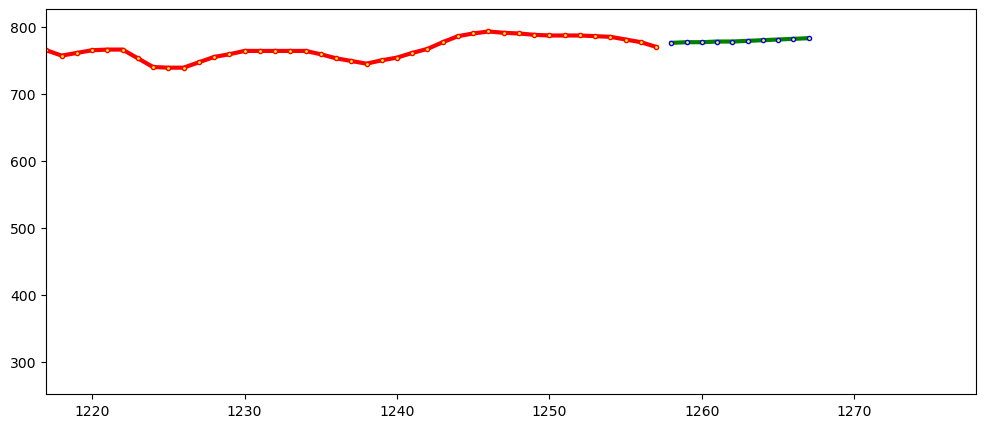

In [121]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=3
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Smoothed_Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=3
        , mec='blue', mew=1, mfc='yellow' )
#plt.xlim([-20,len(S)+N+20])
#plt.ylim([0,1300])
plt.xlim( T_Pred[-1]-5*n_Steps, T_Pred[-1]+1.1*n_Steps )
#plt.ylim([760,795])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

#####   

In [122]:
# save weights
version = '00'

model.save_weights( Project_Name + '_' + version
                  , overwrite    = True 
                  , save_format  = None 
                  , options      = None 
                  )

In [123]:
# load weights
version = '00'
 
model.load_weights( Project_Name  + '_' + version 
                  , by_name       = False 
                  , skip_mismatch = False 
                  , options       = None 
                  )

#####   

In [ ]:
## save weights
#version = 'BEST'    # RMSE = 21.6
#model.save_weights( Project_Name+'_'+version, overwrite=True, save_format=None, options=None )

#####   